In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
from lsst.daf.butler import Butler
import lsst.geom as geom
from astropy.io import ascii as astascii
import glob
import lsst.afw.image as afwImage
import anacal
from astropy.visualization import ZScaleInterval

In [6]:
import fitsio
full = fitsio.read("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim2.fits")
id_list = []
for i, entry in enumerate(full):
    tract_id = entry["tract"]
    patch_db = entry["patch"]
    patch_x = patch_db // 100
    patch_y = patch_db % 100
    patch_id = patch_x + patch_y * 9
    image_dir = (
        "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
    )
    files = glob.glob(os.path.join(image_dir, f"{tract_id}/{patch_id}/*/*"))
    if len(files) > 4:
        id_list.append(i)
# fitsio.write("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/tracts_fdfc_v1_trim3.fits", full[id_list])

In [119]:
obs_repo = '/lustre/work/xiangchong.li/work/hsc_s23b_sim'
obs_collection = 'version1/image'
skymap = 'hsc'

obs_butler = Butler(obs_repo, collections=obs_collection)
obs_registry = obs_butler.registry
skyMap = obs_butler.get('skyMap', skymap=skymap)
tract_id = 10660
patch_id = 13
patch_info = skyMap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()

In [120]:
image_dir = "/lustre/HSC_DR/hsc_ssp/dr4/s23b/data/s23b_wide/unified/deepCoadd_calexp"
fname = glob.glob(os.path.join(image_dir, "%d/%d/i/*" %(tract_id, patch_id)))[0]
exposure = afwImage.ExposureF.readFits(fname)

In [121]:
def make_circular_kernel(radius):
    """Create a binary circular (disk-shaped) kernel."""
    L = 2 * radius + 1
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    return mask.astype(np.int16)

data = pyfits.getdata(f"/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-brightStarMask/tracts/{tract_id}.fits")
patch_y = int(patch_id) // 9
patch_x = int(patch_id) % 9
patch_db = patch_x * 100 + patch_y
data = data[data["patch"] == patch_db]
x, y = wcs.skyToPixelArray(ra=data["ra"], dec=data["dec"], degrees=True)
x = np.int_(x - bbox.getBeginX())
y = np.int_(y - bbox.getBeginY())
mask = np.zeros((bbox.getHeight(), bbox.getWidth())).astype(np.int8)
mask[y, x] = 1

bitValue = exposure.mask.getPlaneBitMask(["SAT"])
mask = mask #| ((exposure.mask.array & bitValue) != 0).astype(np.int16)

radius = 40
kernel = make_circular_kernel(radius)
mask = anacal.mask.sparse_convolve(mask, kernel)
mask = (mask > 2).astype(np.int16)

radius = 20
kernel = make_circular_kernel(radius)
mask = anacal.mask.sparse_convolve(mask, kernel)
mask = (mask > 0).astype(np.int16)

radius = 20
kernel = make_circular_kernel(radius)
mask = anacal.mask.sparse_convolve(mask, kernel)
mask = (mask > 2).astype(np.int16)

radius = 10
kernel = make_circular_kernel(radius)
mask = anacal.mask.sparse_convolve(mask, kernel)
mask = (mask > 2).astype(np.int16)

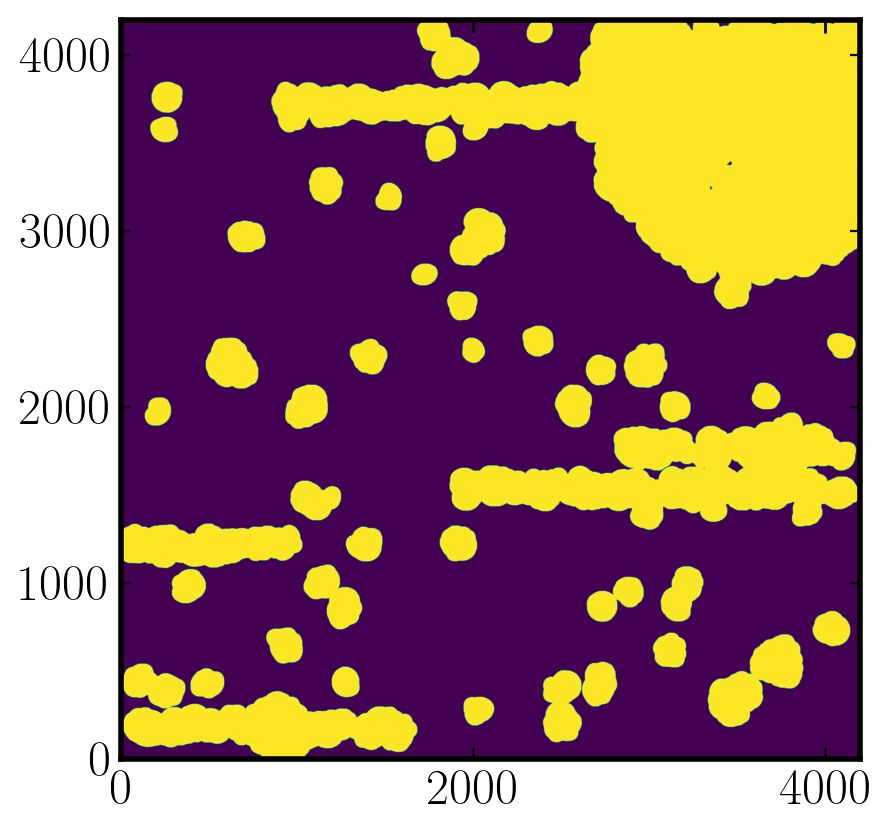

In [122]:
plt.imshow(mask, origin="lower")

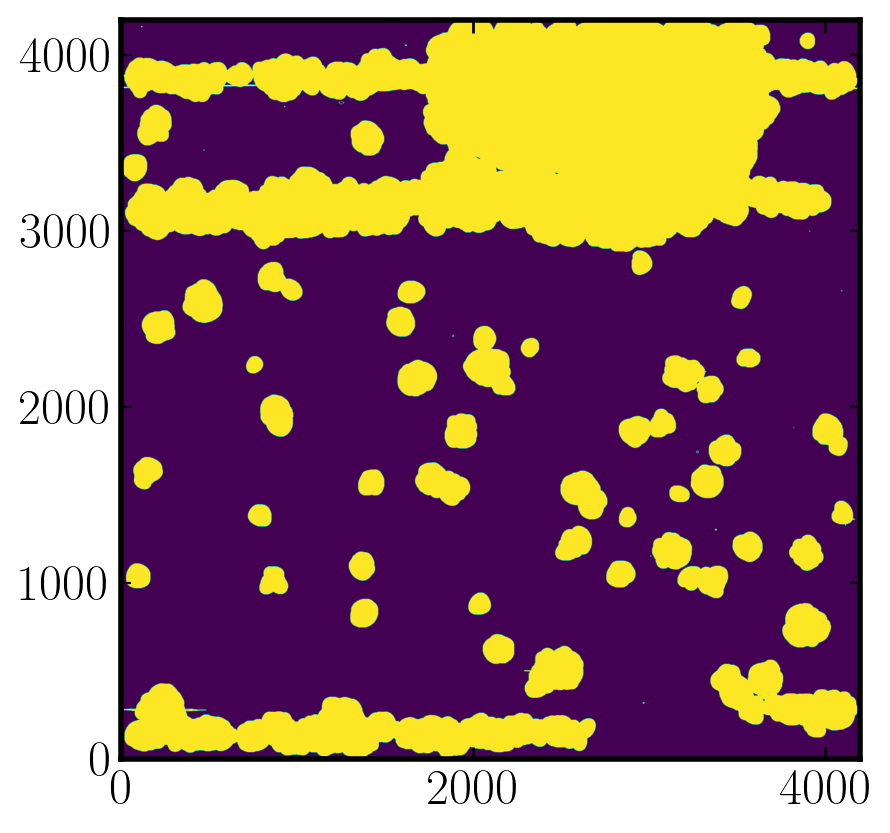

In [44]:
plt.imshow(mask2, origin="lower")

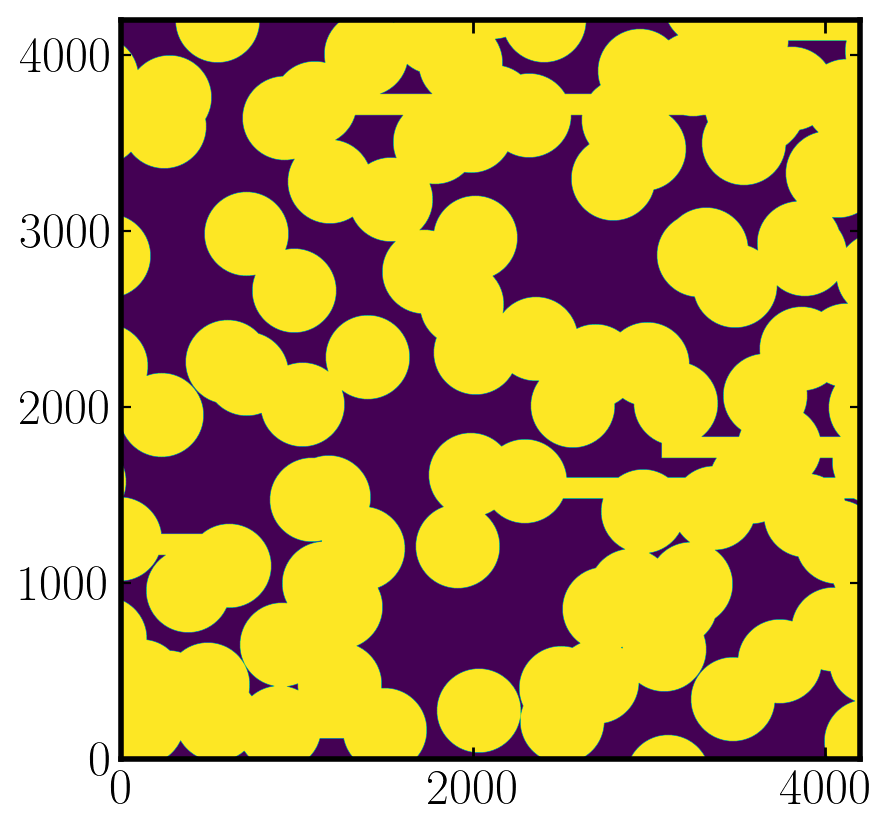

In [85]:
bitValue = exposure.mask.getPlaneBitMask(["BRIGHT_OBJECT"])
mm = ((exposure.mask.array & bitValue) != 0).astype(np.int16)
plt.imshow(mm, origin="lower")

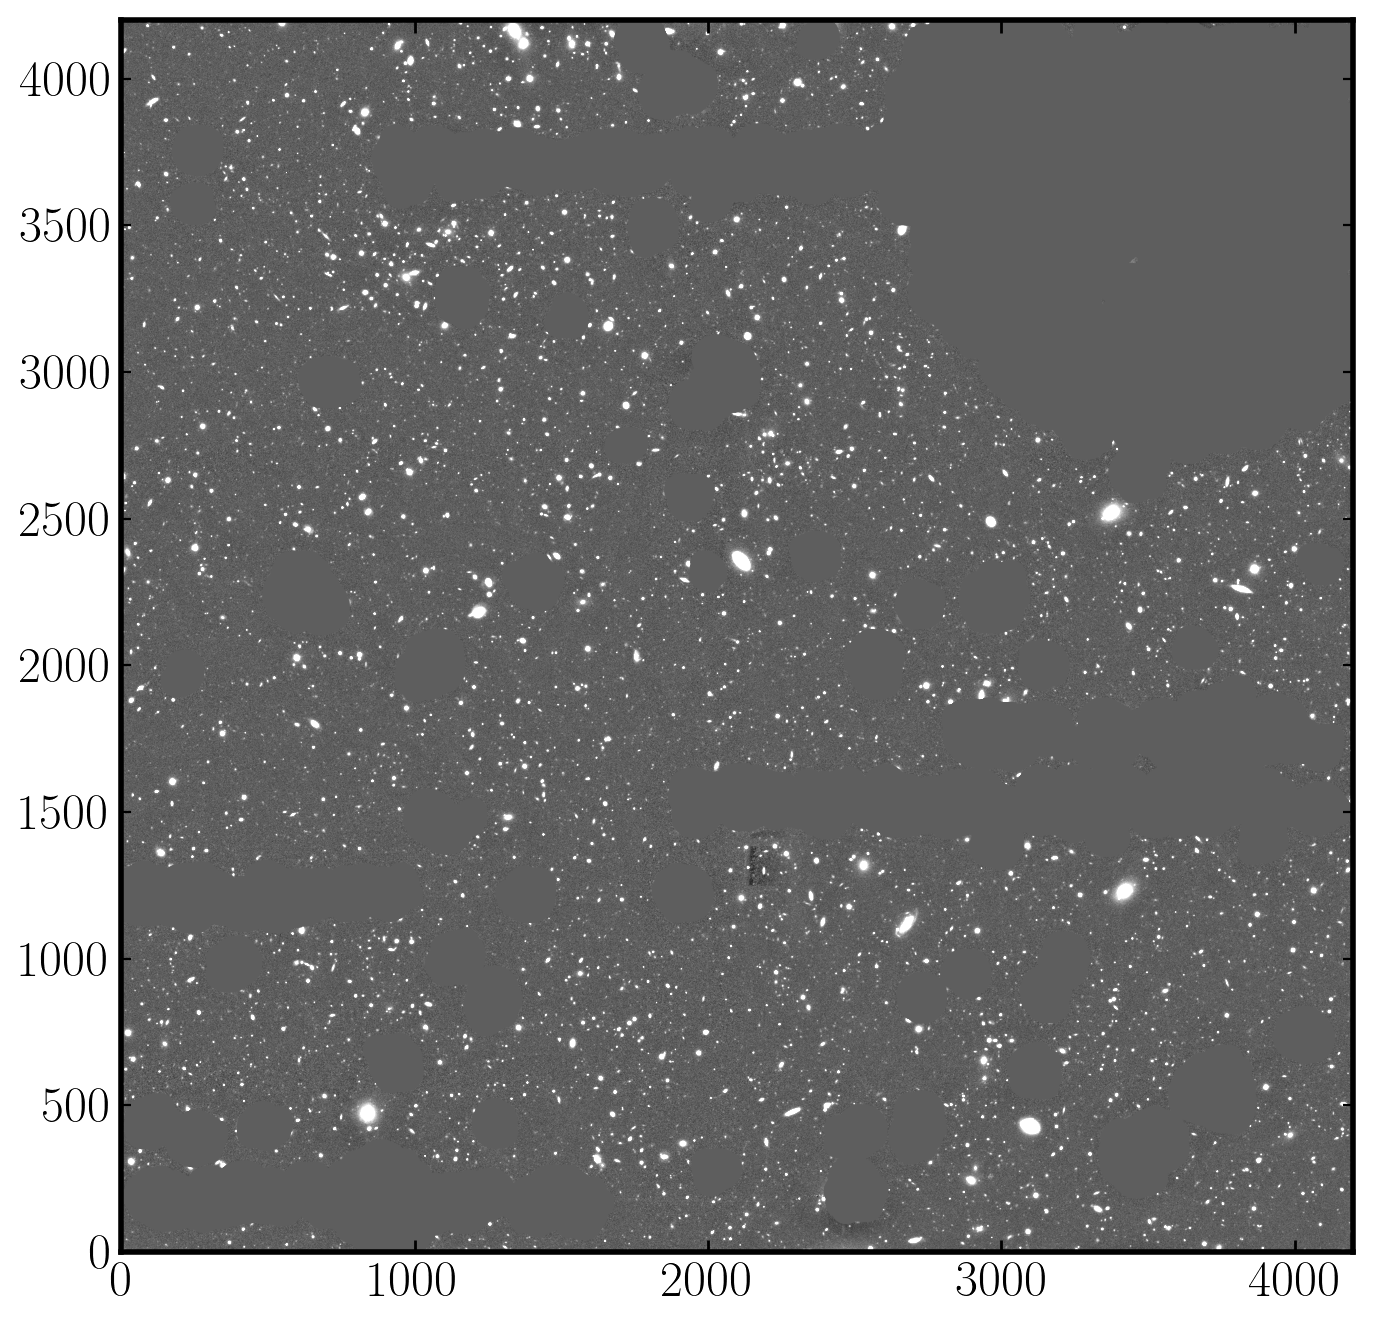

In [123]:
image = exposure.image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)
mask2 = mask | ((exposure.mask.array & bitValue) != 0).astype(np.int16)
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image * ((mask - 1) * -1), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

In [ ]:
plt.imshow(mask, origin="lower")

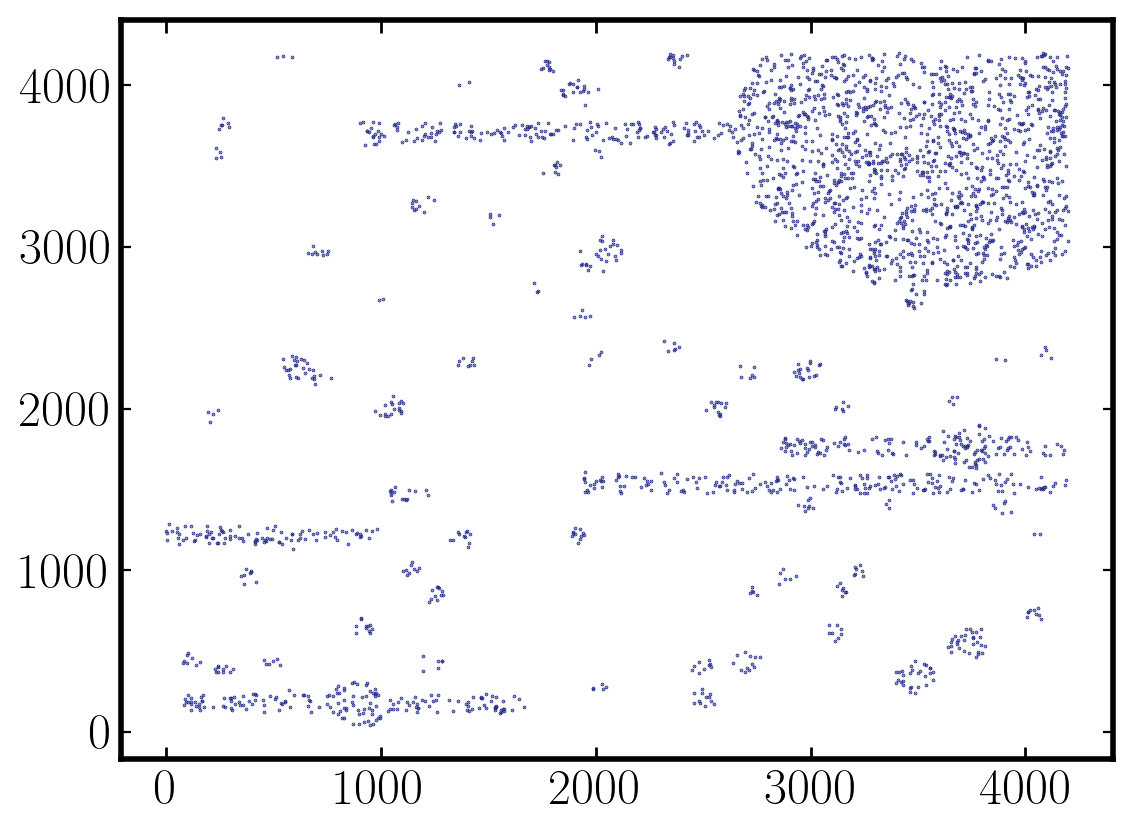

In [113]:
plt.scatter(x, y, s=0.1)

In [1]:
if False:
    cat = pyfits.getdata("/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-brightStarMask/random.fits")
    tract_list = np.unique(cat["tract"])
    for tract in tract_list:
        cc = cat[cat["tract"] == tract]
        pyfits.writeto(
            f"/lustre/work/xiangchong.li/work/hsc_s23b_data/catalogs/database/s23b-brightStarMask/tracts/{tract}.fits",
            cc,
        )